In [2]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [3]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

%watermark -a 'Ethen' -d -t -v -p numpy,matplotlib,sklearn

Ethen 2017-09-14 16:33:30 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
matplotlib 2.0.0
sklearn 0.18.1


In [16]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification, load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Calibration

In [23]:
import pandas as pd

filename = 'BikeBuyerWithLocation.csv'
data = pd.read_csv(filename, encoding = 'latin1')

# columns that we won't be using at all
drop_cols = ['ID', 'Latitude', 'Longitude', 'City', 'Zip Code', 'Country']
data = data.drop(drop_cols, axis = 1)
print('dimensions: ', data.shape)
data.head()

dimensions:  (10000, 12)


,Marital Status,Gender,Yearly Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,BikeBuyer
0,Married,Female,20000,0,Partial College,Manual,No,1,0-1 Miles,Europe,47,Yes
1,Married,Female,10000,1,High School,Manual,No,1,1-2 Miles,Europe,46,No
2,Single,Female,10000,1,High School,Manual,No,1,2-5 Miles,Europe,46,No
3,Single,Male,10000,1,High School,Manual,No,1,1-2 Miles,Europe,46,No
4,Single,Male,10000,0,Partial College,Manual,No,1,2-5 Miles,Europe,64,No


In [24]:
from sklearn.preprocessing import LabelEncoder

label_col = 'BikeBuyer'
label = data[label_col]
data = data.drop(label_col, axis = 1)
label_encode = LabelEncoder()
y = label_encode.fit_transform(label)

# slightly imbalanced problem
print('original labels: ', label_encode.classes_)
print('encoded labels distribution:', np.bincount(y))

test_size = 0.2
random_state = 1234
data_train, data_test, y_train, y_test = train_test_split(
    data, y, test_size = test_size, random_state = random_state, stratify = y)

original labels:  ['No' 'Yes']
encoded labels distribution: [9000 1000]


In [31]:
num_cols = ['Yearly Income', 'Children', 'Cars', 'Age']
cat_cols = ['Marital Status', 'Gender', 'Education', 'Occupation',
            'Home Owner', 'Commute Distance', 'Region']

from preprocess import Preprocess
preprocess = Preprocess(num_cols, cat_cols)
X_train = preprocess.fit_transform(data_train)
X_test = preprocess.transform(data_test)
X_train

array([[ 0.11431662, -0.69821864,  0.29928303, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.35562367,  2.41917677,  2.07544344, ...,  0.        ,
         0.        ,  1.        ],
       [-0.81666367,  1.17221861,  0.29928303, ...,  1.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.73497015, -0.69821864,  0.29928303, ...,  0.        ,
         1.        ,  0.        ],
       [-0.19601014, -0.69821864,  0.29928303, ...,  0.        ,
         1.        ,  0.        ],
       [-1.12699043, -0.69821864,  0.29928303, ...,  0.        ,
         1.        ,  0.        ]])

In [32]:
# try out some classifiers
lr = LogisticRegression()
svc = LinearSVC(loss = 'hinge', C = 1.0)
rf = RandomForestClassifier(n_estimators = 100)
clfs = [
    (lr, 'Logistic Regression'),
    (svc, 'Support Vector Machine'),
    (rf, 'Random Forest')
]

In [17]:
# X, y = make_classification(n_samples = 10000, n_features = 20,
#                            n_informative = 2, n_redundant = 2)

# iris = load_iris()
# X = iris.data
# y = iris.target

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size = 0.2, random_state = 1234, stratify = y)

# train_samples = 100  # Samples used for training the models
# X_train = X[:train_samples]
# X_test = X[train_samples:]
# y_train = y[:train_samples]
# y_test = y[train_samples:]

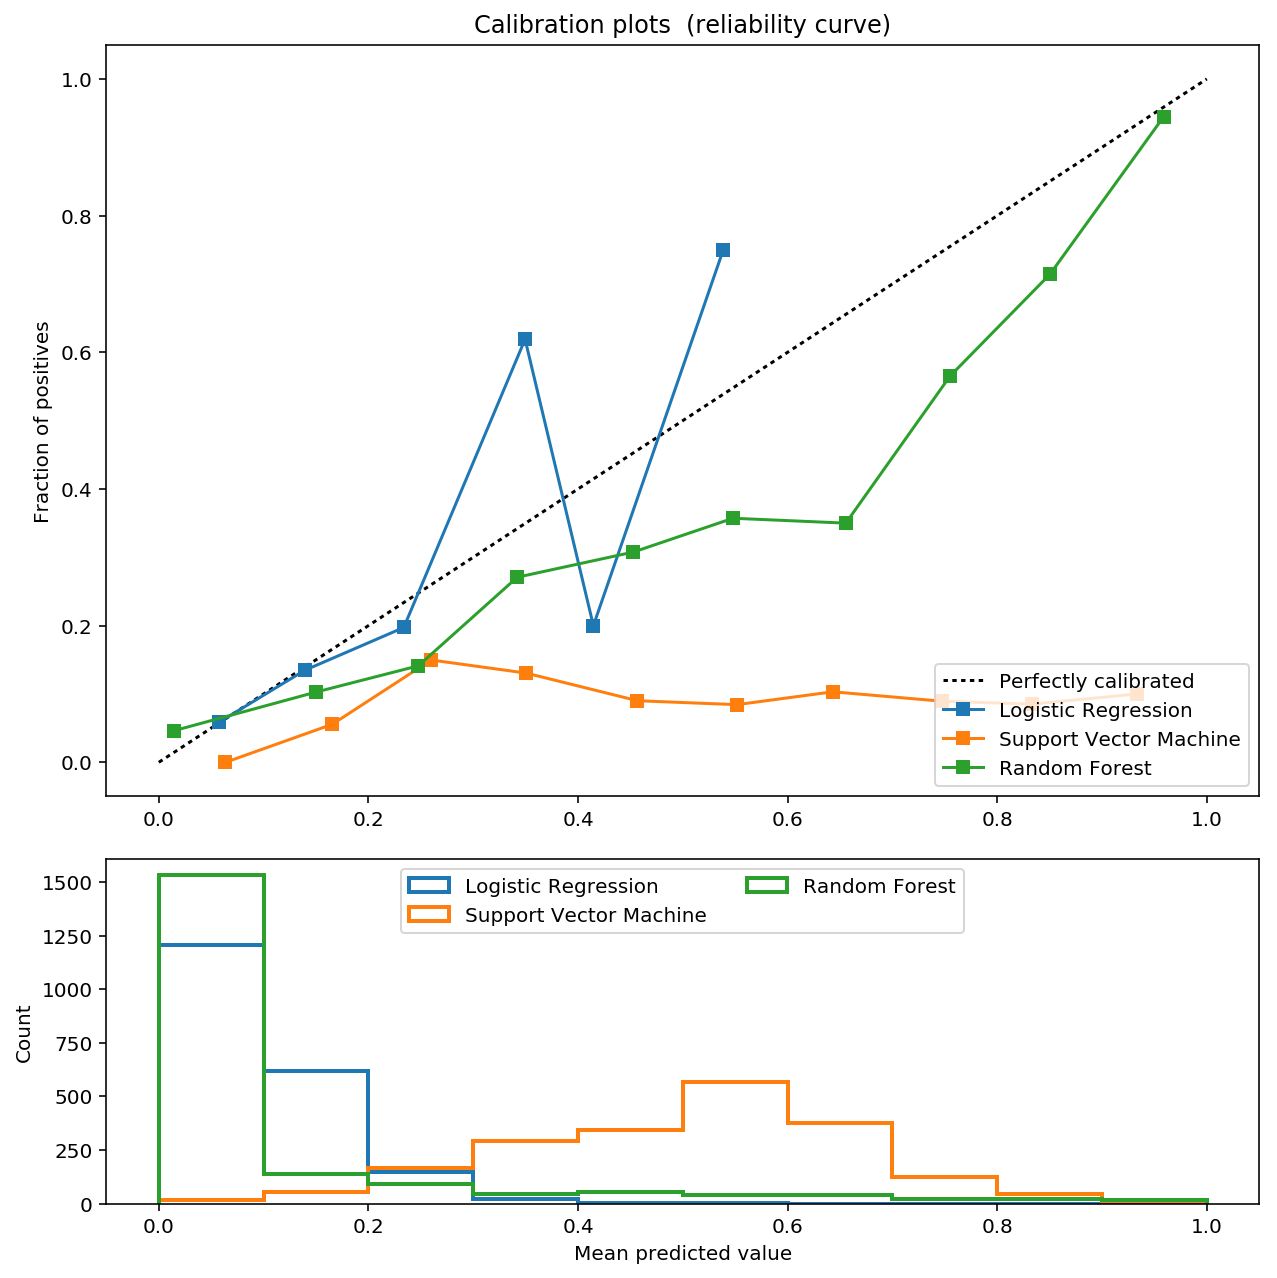

In [33]:
plt.figure(figsize = (9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label = "Perfectly calibrated")


for clf, name in clfs:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_test)[:, 1]
    else:
        # some classifier such as LinsearSVC does not have
        # the predict_proba method, in that case we use
        # the decision_function
        score = clf.decision_function(X_test)
        min_score = score.min()
        proba = (score - min_score) / (score.max() - min_score)

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, proba, n_bins = 10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label = name)

    ax2.hist(proba, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [34]:
clf = RandomForestClassifier(n_estimators = 100)
clf_sigmoid = CalibratedClassifierCV(clf, cv = 5, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

In [35]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
proba = rf.predict_proba(X_test)[:, 1]

In [36]:
proba

array([ 0.        ,  0.47366667,  0.26261905, ...,  0.23809524,
        0.        ,  0.1695184 ])

In [37]:
prob_pos_sigmoid

array([ 0.05305156,  0.32587492,  0.17627788, ...,  0.16419551,
        0.05258215,  0.11259376])

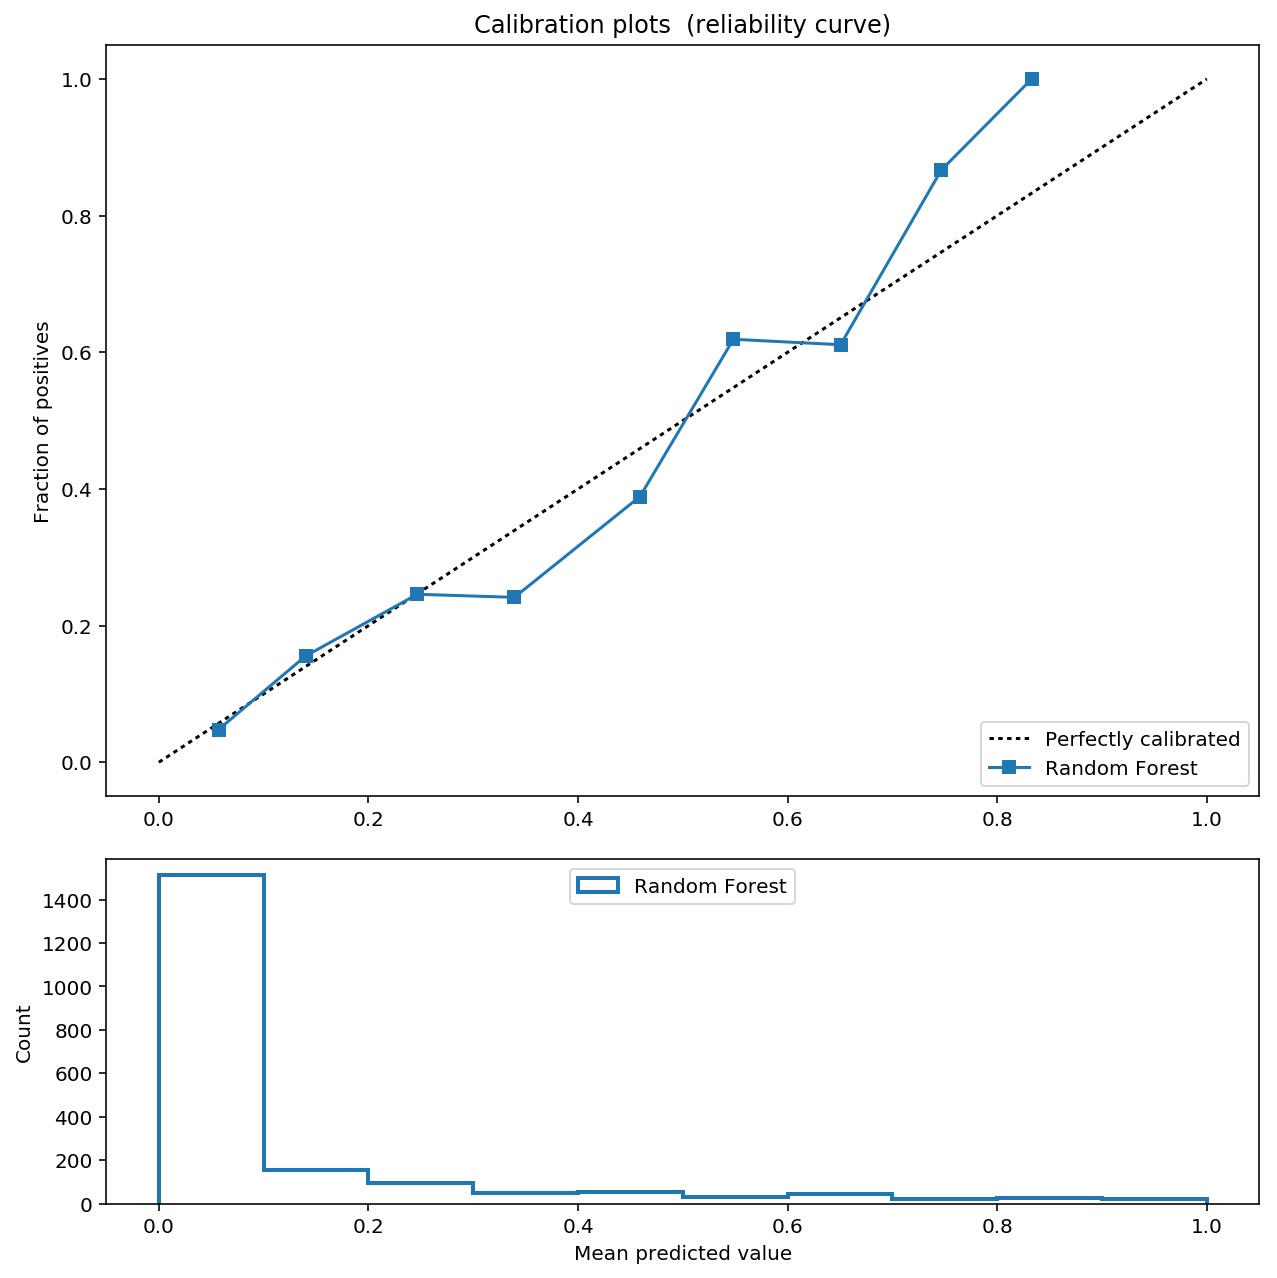

In [38]:
plt.figure(figsize = (9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label = "Perfectly calibrated")

    
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos_sigmoid, n_bins = 10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label = name)

ax2.hist(proba, range=(0, 1), bins=10, label=name,
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [ ]:
hi

In [ ]:
# split into train/valid/test set

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)